# Bubble Answer Classification

Part of Rully: AI-Powered Universal Bubble Sheet Grader

- Name: Rijal Ghodi
- Email: rijalgdev@gmail.com
- Github: https://github.com/rijalghodi
- Portfolio: https://zalcode.my.id


<img src="https://t3.ftcdn.net/jpg/03/07/88/98/360_F_307889892_dSTifVpnJZiuq82l1efgXSjcABKAwSlP.jpg" width="600px" height="auto" alt="Bubble Sheet Illustration"/>

## Objective

This project aims to create a deep learning model to classify bubble answer into 4 category: default, filled, crossed, and invalid.

## Dataset

Dataset can be downloaded from [here](https://universe.roboflow.com/zal-code/bubble-answer)

This dataset contains images of individual bubble answers from various answer sheets commonly used in Indonesian schools. Each image is categorized into one of four bubble types:

1. Default: The bubble is unmarked and remains in its original state.
2. Filled: The bubble is completely filled in, indicating a selected answer.
3. Crossed: The bubble has a cross mark, which is another common way students indicate their answer.
4. Invalid: The bubble is marked in an invalid manner or the image does not contain a bubble.

The dataset is divided into three subsets:

1. Train: Used to train the AI models.
2. Validation: Used to validate the model during training and prevent overfitting.
3. Test: Used to test the final model's performance.

Dataset Folder Structure

```
.
├── train/
│   ├── 1.png
│   ├── 2.png
│   ├── ...
│   └── _classes.csv
├── test/
│   ├── 1.png
│   ├── 2.png
│   ├── ...
│   └── _classes.csv
└── valid/
    ├── 1.png
    ├── 2.png
    ├── ...
    └── _classes.csv
```


## Project Overview

1. Preparation: Import libraries and load the dataset.
2. Exploratory Data Analysis (EDA): Analyze the dataset to understand its structure and characteristics.
3. Feature Engineering: Preprocess and transform features to enhance model performance.
4. Build Base Model: Develop an initial model to establish a baseline performance.
5. Hyperparameter Tuning: Optimize parameters for the model to improve predictive accuracy.
6. Test the accuracy of final model
7. Save Model: Save the final trained model for future use.

## 1. Preparation


### Import Libraries

In [ ]:
!pip install roboflow

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.6 MB/s eta 0:00:00


In [ ]:
# Import Necessary Libraries

# Essential libraries for basic data processing
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf

# Libraries for Machine learning evaluation
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

# Libraries for deep learning
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Libraries for hyperparameter tuning
import optuna

# Libraries for load dataset
from roboflow import Roboflow

In [ ]:
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
set_seed(42)

### Load Dataset

In [ ]:
rf = Roboflow(api_key="CldDXdhCn0T8MMg7qecL")
project = rf.workspace("zal-code").project("bubble-answer")
version = project.version(24)
dataset = version.download("multiclass")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Bubble-Answer-24 in multiclass:: 100%|██████████| 880/880 [00:00<00:00, 8273.99it/s]


In [ ]:
# Load train, validation, and test dataset

WORK_DIR = '/content/Bubble-Answer-24' # Change this to your dataset folder
TRAIN_DIR = f'{WORK_DIR}/train' # Change this to your dataset folder
VALID_DIR = f'{WORK_DIR}/valid' # Change this to your dataset folder
TEST_DIR = f'{WORK_DIR}/test' # Change this to your dataset folder

train_df = pd.read_csv(f'{TRAIN_DIR}/_classes.csv')
valid_df = pd.read_csv(f'{VALID_DIR}/_classes.csv')
test_df = pd.read_csv(f'{TEST_DIR}/_classes.csv')

In [ ]:
train_df.head()

,filename,Unlabeled,crossed,default,filled,invalid
0,Screenshot-2024-05-26-112654_png.rf.001d3666a4...,0,0,0,1,0
1,Screenshot-2024-05-26-135459_png.rf.004fc3aba5...,0,1,0,0,0
2,Screenshot-2024-05-28-012202_png.rf.0136f3f226...,0,0,0,0,1
3,Screenshot-2024-05-26-114413_png.rf.00e174bf26...,0,0,0,0,1
4,Screenshot-2024-05-26-112526_png.rf.00266b72e0...,0,0,1,1,0


The dataset consists of filename and its one hot encoded label (Unlabeled, crossed, default, filled, invalid).

We need to store the label columns

In [ ]:
label_columns = [' Unlabeled', ' crossed', ' default', ' filled', ' invalid']

## EDA (Exploratory Data Analysis)

Lets try to display sample images and its labels

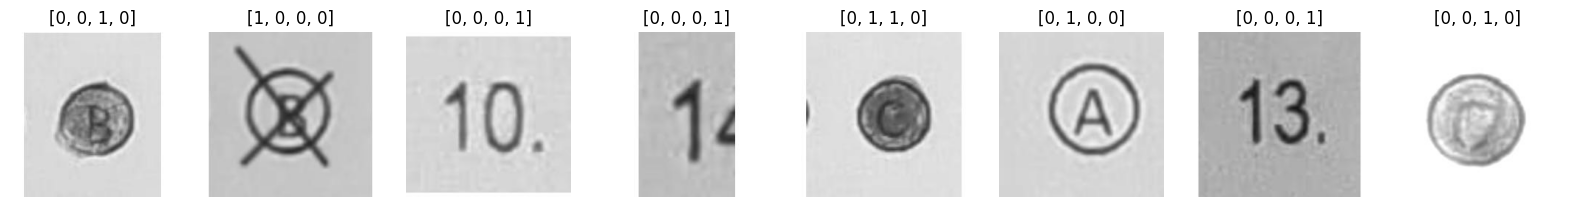

In [45]:
train_list = train_df.head(8).values.tolist()

fig, axs = plt.subplots(1, 8, figsize=(20, 4))  # 1 row, 5 columns

for i, train in enumerate(train_list):
    img = mpimg.imread(f"{TRAIN_DIR}/{train[0]}")
    plt.imshow(img)
    plt.axis('off')
    axs[i].imshow(img)
    axs[i].set_title(f"[{train[2]}, {train[3]}, {train[4]}, {train[5]}]")
    axs[i].axis('off')
plt.show()

In this section we will try to analyze the distribution of dataset

In [47]:
def display_dataset_dist(dataset, name):
    label_counts = dataset[label_columns].sum()

    # Plotting the bar plot
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x=label_counts.index, y=label_counts.values, palette="YlOrBr", legend=False)

    # Adding annotations
    for index, value in enumerate(label_counts.values):
        barplot.text(index, value + 0.1, str(value), ha='center', fontsize=10)

    # Adding titles and labels
    plt.title(f'Frequency of Labels in {name} Dataset')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



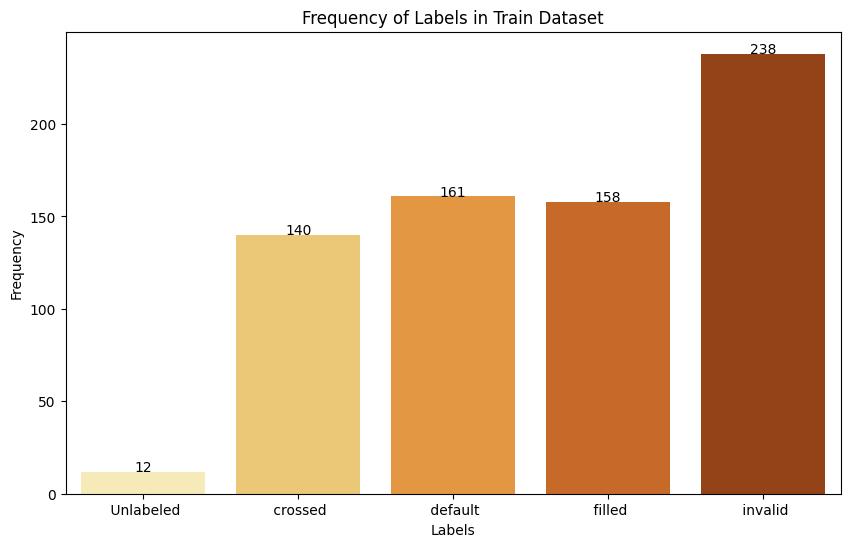

In [48]:
display_dataset_dist(train_df, "Train")



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



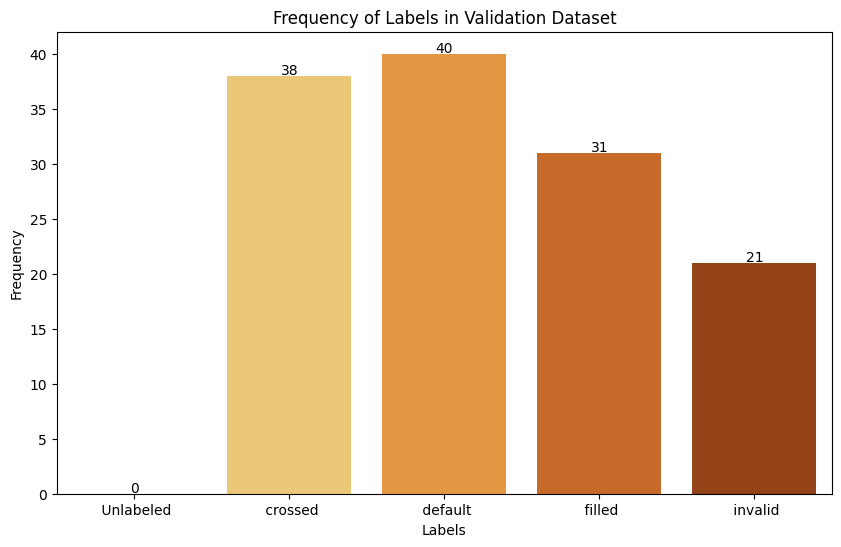

In [49]:
display_dataset_dist(valid_df, "Validation")



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



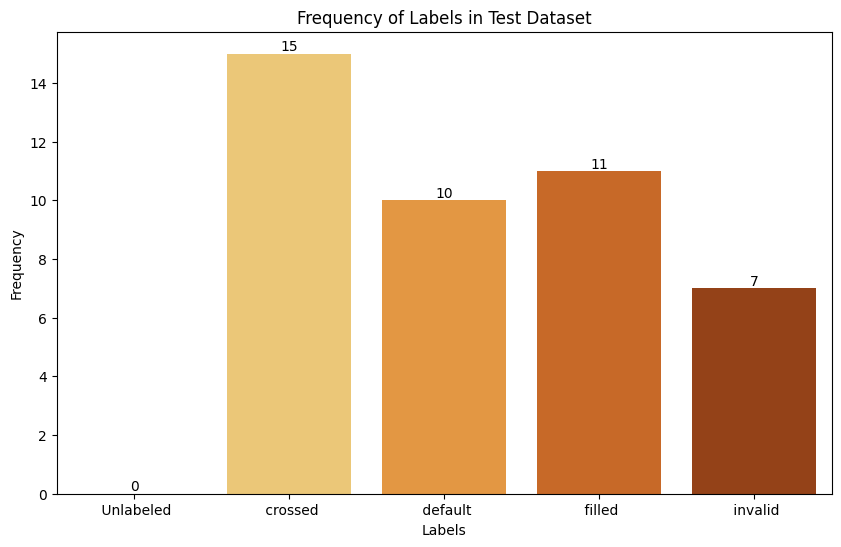

In [50]:
display_dataset_dist(test_df, "Test")

data distribution is normal

## Feature Engineering

## Missing Value Handling

We define a missing value as an invalid value. This includes images that:

1. Have no label at all.
2. Are labeled as "Unlabeled".
3. Have more than one label.

We will remove all rows with invalid values.

In [51]:
def remove_invalid_rows(df):
    # Replace NaN values with 0 for proper comparison
    df = df.fillna(0)

    # Condition for rows with no label (all columns are 0)
    no_label_condition = (df[' default'] == 0) & (df[' crossed'] == 0) & (df[' filled'] == 0) & (df[' invalid'] == 0)

    # Condition for rows labeled as "Unlabeled"
    unlabeled_condition = df[' Unlabeled'] == 1

    # Condition for rows with more than one label
    multiple_labels_condition = (df[[' default', ' crossed', ' filled', ' invalid']].sum(axis=1) > 1)

    # Combine all conditions for invalid rows
    invalid_condition = no_label_condition | unlabeled_condition | multiple_labels_condition

    # Remove invalid rows
    df_cleaned = df[~invalid_condition]

    return df_cleaned

In [52]:
# Remove invalid rows from all dataset
train_df = remove_invalid_rows(train_df)
valid_df = remove_invalid_rows(valid_df)
test_df = remove_invalid_rows(test_df)

## Build Base Model

### Convert Dataset Into Data Generator

We want to extract only meaningful label, so we dont need Unlabeled

In [53]:
label_columns = [' crossed', ' default', ' filled', ' invalid']

In [55]:
# Extract filenames and labels of train data

filenames = train_df['filename'].values
labels = train_df[label_columns].values

# Create a dictionary to map filenames to their labels
train_labels_dict = {filenames[i]: labels[i] for i in range(len(filenames))}

In [56]:
# Extract filenames and labels of validation data

filenames = valid_df['filename'].values
labels = valid_df[label_columns].values

# Create a dictionary to map valid_filenames to their labels
valid_labels_dict = {filenames[i]: labels[i] for i in range(len(filenames))}


In [57]:
# Extract filenames and labels of test data

filenames = test_df['filename'].values
labels = test_df[label_columns].values

# Create a dictionary to map test_filenames to their labels
test_labels_dict = {filenames[i]: labels[i] for i in range(len(filenames))}

In [58]:
# Create class to load image

class CustomDataGenerator(Sequence):
    def __init__(self, image_dir, labels_dict, batch_size=32, img_size=(224, 224)):
        self.image_dir = image_dir
        self.labels_dict = labels_dict
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_filenames = list(labels_dict.keys())

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_filenames = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = [img_to_array(load_img(os.path.join(self.image_dir, filename), target_size=self.img_size)) / 255.0 for filename in batch_filenames]
        batch_labels = [self.labels_dict[filename] for filename in batch_filenames]
        return np.array(batch_images), np.array(batch_labels)

In [61]:
# Initialize the data generator
batch_size = 32
img_size = (224, 224)
train_generator = CustomDataGenerator(TRAIN_DIR, train_labels_dict, batch_size, img_size)
valid_generator = CustomDataGenerator(VALID_DIR, valid_labels_dict, batch_size, img_size)
test_generator = CustomDataGenerator(TEST_DIR, test_labels_dict, batch_size, img_size)

## Deep Learning Base Model

**Problem Identification**

We need to classify images into four categories: default, crossed, filled, and invalid.

**Strategy**

To ensure fast performance on teachers' mobile devices, we require a simple yet accurate model. Instead of building from scratch, we'll use MobileNet with pre-trained ImageNet weights for transfer learning.

Our base model will include:

- MobileNetV2 Convolutional Layers
- Global Average Pooling 2D
- ReLU Layer with 512 neurons
- ReLU Layer with 256 neurons
- ReLU Layer with 128 neurons
- Softmax Layer with 4 neurons

We will run this using learning rata 0.001 and 50 epoch

In [62]:
# Set the image size
img_size = (224, 224)

# Load the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_size + (3,))

for layer in base_model.layers:
    layer.trainable = False  # Freeze the base model layers

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# Output layer for 4 classes: default, filled, crossed, invalid
predictions = Dense(4, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 [==============================] - 1s 0us/step


In [63]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(train_generator, epochs=20,
                    validation_data=valid_generator,
                    callbacks=[early_stopping])

Epoch 1/20
22/22 [==============================] - 45s 2s/step - loss: 0.2693 - accuracy: 0.9072 - val_loss: 0.0760 - val_accuracy: 0.9844
Epoch 2/20
22/22 [==============================] - 35s 2s/step - loss: 0.1037 - accuracy: 0.9735 - val_loss: 0.1466 - val_accuracy: 0.9453
Epoch 3/20
22/22 [==============================] - 37s 2s/step - loss: 0.0803 - accuracy: 0.9853 - val_loss: 0.0766 - val_accuracy: 0.9922
Epoch 4/20
22/22 [==============================] - 34s 2s/step - loss: 0.0326 - accuracy: 0.9882 - val_loss: 0.0573 - val_accuracy: 0.9922
Epoch 5/20
22/22 [==============================] - 39s 2s/step - loss: 0.0239 - accuracy: 0.9926 - val_loss: 0.0616 - val_accuracy: 0.9922
Epoch 6/20
22/22 [==============================] - 35s 2s/step - loss: 0.0120 - accuracy: 0.9985 - val_loss: 0.1676 - val_accuracy: 0.9609
Epoch 7/20
22/22 [==============================] - 35s 2s/step - loss: 0.0396 - accuracy: 0.9882 - val_loss: 0.0864 - val_accuracy: 0.9531
Epoch 8/20
22/22 [==

## Base Model Evaluation

### Functions Necessary for Evaluation

In [64]:
def plot_learning_curve(history):
    # Get training and validation metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Define the number of epochs
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plots
    plt.show()

In [66]:
def display_evaluation_charts(y_true, y_pred, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports
    and confusion matrix using the Viridis color palette.
    '''

    # Generate the classification report
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.round(2)

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(figsize=(12, 5), ncols=2)

    # Create a table from the DataFrame
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.set_frame_on(False)
    table = ax1.table(cellText=report_df.values, colLabels=report_df.columns, rowLabels=report_df.index, cellLoc='center', loc='center')

    # Adjust table layout
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(0.8, 1.5)
    ax1.set_title('Classification Metrics', fontsize=14)

    # Plot the confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax2, cmap='YlOrBr')
    ax2.set_title(f'Confusion Matrix', fontsize=14)
    ax2.grid(False)
    # Add a general title to the plot
    fig.suptitle(f"Evaluation of {model_name}", fontsize=16)

    # Adjust subplot layout for better appearance
    # plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.8)  # Adjust the top to accommodate the suptitle
    plt.show()

### Base Model Evaluation

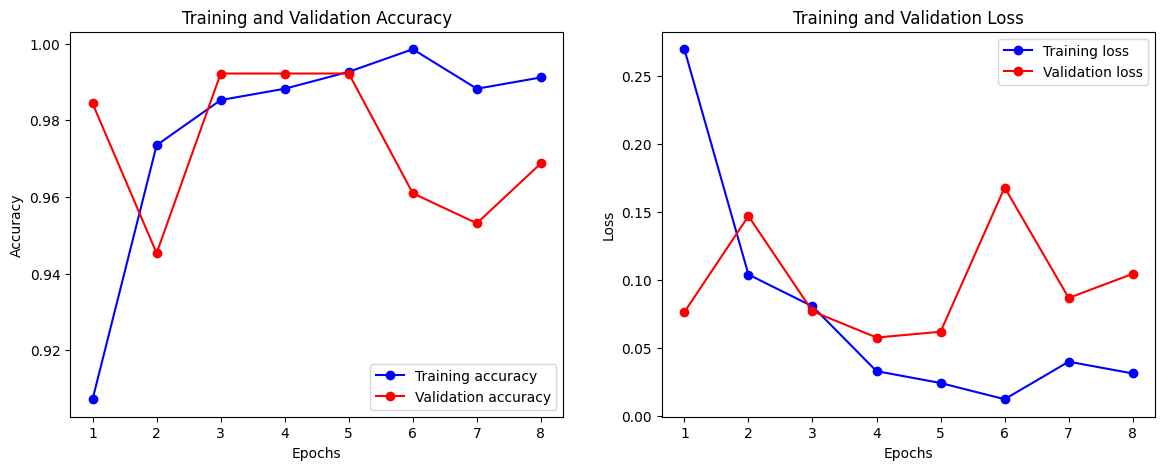

In [67]:
plot_learning_curve(history)

22/22 [==============================] - 30s 1s/step


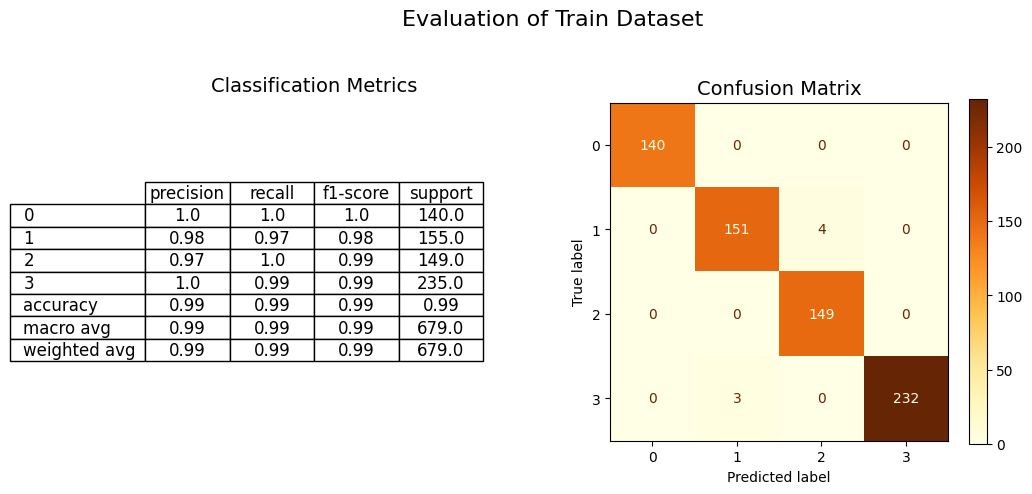

In [68]:
y_train_pred_hot = model.predict(train_generator)
y_train_pred = np.argmax(y_train_pred_hot, axis=1)
y_train_true = np.argmax(np.array(list(train_labels_dict.values())), axis=1)

display_evaluation_charts(y_train_true, y_train_pred, "Train Dataset")

4/4 [==============================] - 5s 1s/step


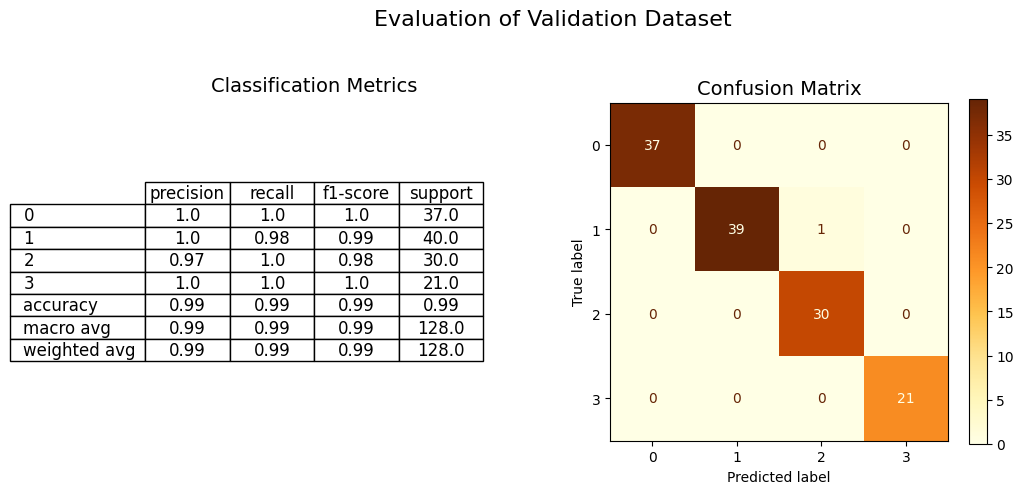

In [69]:
y_valid_pred_hot = model.predict(valid_generator)
y_valid_pred = np.argmax(y_valid_pred_hot, axis=1)
y_valid_true = np.argmax(np.array(list(valid_labels_dict.values())), axis=1)

display_evaluation_charts(y_valid_true, y_valid_pred, "Validation Dataset")

The accuracy of the training dataset is 0.55, while the validation dataset accuracy is 0.78. This low accuracy in the training dataset indicates that the model has high bias, which may be caused by an insufficient dataset or incorrect hyperparameters, such as the learning rate.

In addition to accuracy, we will examine precision and recall. Precision is crucial when the cost of a false positive is high, whereas recall is important when the cost of a false negative is high.

For the training dataset, both precision and recall for each class range between 0.4 to 1.0, which is acceptable, except for class 2 (filled). The model struggles to identify filled bubbles in the training dataset, with a precision and recall of 0.01. This class is almost always mispredicted as class 1 or 0 (default or crossed), as illustrated in the confusion matrix.

In the validation dataset, both precision and recall for each class also perform well, with scores ranging between 0.5 to 1.0, except for class 2, which has a precision of 0.22 and a recall of 0.35. Class 2 is often mispredicted as class 1 (default).

To address this issue, we will conduct hyperparameter tuning

## Hyperparameter Tuning

In this hyperparameter tuning process, we will vary the learning rate (0.001 and 0.00001) and the number of neurons in the first fully connected layer of the neural network (512 and 1024). Specifically, we will use Optuna for this task. Optuna is a powerful hyperparameter optimization framework that allows for efficient and automated tuning. It uses techniques like Bayesian optimization to intelligently explore the hyperparameter space, which helps in finding the optimal set of hyperparameters more quickly and effectively than manual tuning or simple grid search methods.

In [71]:
def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    neurons = trial.suggest_int('neurons', 512, 1024)

    # Build the model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_size + (3,))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(neurons, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(4, activation='softmax')(x)  # Assuming 3 classes for the output

    model = Model(inputs=base_model.input, outputs=x)

    for layer in base_model.layers:
        layer.trainable = False  # Freeze the base model layers

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    model.fit(train_generator, epochs=20, validation_data=valid_generator, callbacks=[early_stopping], verbose=False)

    # Evaluate the model
    train_score = model.evaluate(train_generator, verbose=False)
    valid_score = model.evaluate(valid_generator, verbose=False)

    return train_score[1] * 0.5 + valid_score[1] * 0.5  # Return weighted accuracy from both train and valid dataset

In [72]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print(f"Best hyperparameters: {study.best_params}")
print(f"Best validation accuracy: {study.best_value}")

[I 2024-06-01 16:03:17,622] A new study created in memory with name: no-name-b1253064-7d54-4256-9ad7-0fd596f4f7b7
[I 2024-06-01 16:08:16,915] Trial 0 finished with value: 0.9835753440856934 and parameters: {'learning_rate': 0.005829731712334294, 'neurons': 1017}. Best is trial 0 with value: 0.9835753440856934.
[I 2024-06-01 16:14:12,308] Trial 1 finished with value: 0.9894663691520691 and parameters: {'learning_rate': 0.00010198141888780305, 'neurons': 926}. Best is trial 1 with value: 0.9894663691520691.
[I 2024-06-01 16:20:02,134] Trial 2 finished with value: 0.9894663691520691 and parameters: {'learning_rate': 0.0034403260056535662, 'neurons': 911}. Best is trial 1 with value: 0.9894663691520691.
[I 2024-06-01 16:24:52,340] Trial 3 finished with value: 0.9862964749336243 and parameters: {'learning_rate': 0.0006499436499921779, 'neurons': 720}. Best is trial 1 with value: 0.9894663691520691.
[I 2024-06-01 16:31:30,100] Trial 4 finished with value: 0.9916754961013794 and parameters: {

Best hyperparameters: {'learning_rate': 0.00016561025506576358, 'neurons': 706}
Best validation accuracy: 0.9916754961013794


## Evaluate Best Model From Hyperparameter Tuning

In [73]:
# Construct Best Model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(706, activation='relu')(x) # use neuron number from best_params
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# Output layer for 4 classes: default, filled, crossed, invalid
predictions = Dense(4, activation='softmax')(x)

# Define the model
best_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
best_optimizer = Adam(learning_rate=0.000165) # use learning rate from best_params
best_model.compile(optimizer=best_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
# Fit the model
best_history = best_model.fit(train_generator, epochs=20,
                    validation_data=valid_generator,
                    callbacks=[early_stopping])

Epoch 1/20
22/22 [==============================] - 39s 2s/step - loss: 0.4600 - accuracy: 0.8675 - val_loss: 0.1114 - val_accuracy: 0.9844
Epoch 2/20
22/22 [==============================] - 38s 2s/step - loss: 0.0866 - accuracy: 0.9838 - val_loss: 0.0611 - val_accuracy: 0.9922
Epoch 3/20
22/22 [==============================] - 50s 2s/step - loss: 0.0584 - accuracy: 0.9838 - val_loss: 0.0552 - val_accuracy: 0.9922
Epoch 4/20
22/22 [==============================] - 36s 2s/step - loss: 0.0477 - accuracy: 0.9853 - val_loss: 0.0664 - val_accuracy: 0.9844
Epoch 5/20
22/22 [==============================] - 35s 2s/step - loss: 0.0421 - accuracy: 0.9882 - val_loss: 0.0547 - val_accuracy: 0.9922
Epoch 6/20
22/22 [==============================] - 36s 2s/step - loss: 0.0309 - accuracy: 0.9867 - val_loss: 0.0506 - val_accuracy: 0.9922
Epoch 7/20
22/22 [==============================] - 36s 2s/step - loss: 0.0187 - accuracy: 0.9926 - val_loss: 0.0402 - val_accuracy: 0.9922


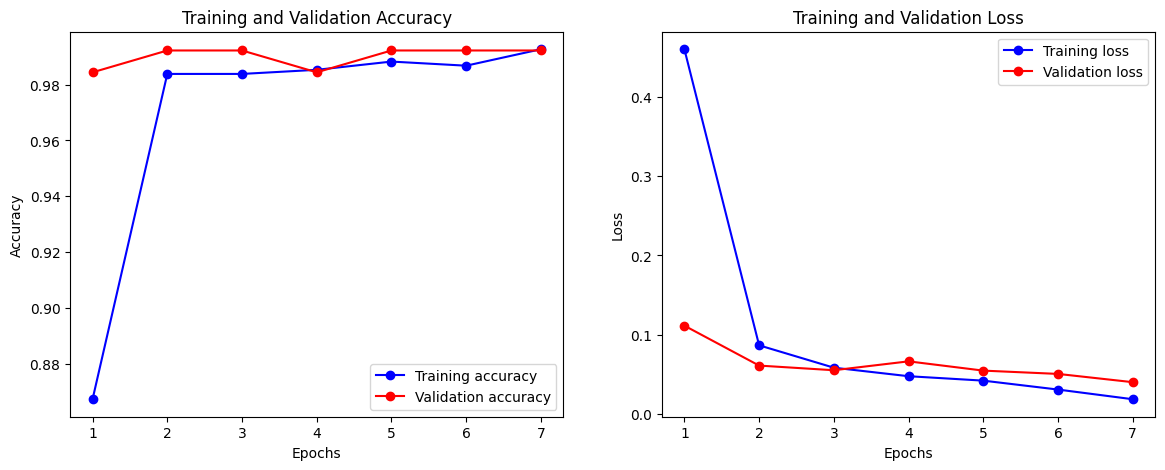

In [76]:
plot_learning_curve(best_history)

22/22 [==============================] - 31s 1s/step


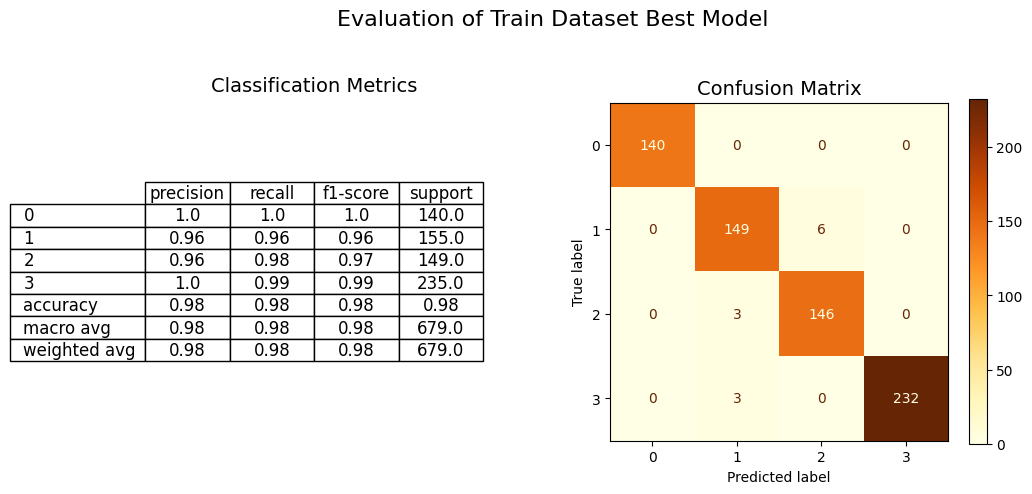

In [75]:
y_best_train_pred_hot = best_model.predict(train_generator)
y_best_train_pred = np.argmax(y_best_train_pred_hot, axis=1)
y_best_train_true = np.argmax(np.array(list(train_labels_dict.values())), axis=1)

display_evaluation_charts(y_best_train_true, y_best_train_pred, "Train Dataset Best Model")

4/4 [==============================] - 5s 1s/step


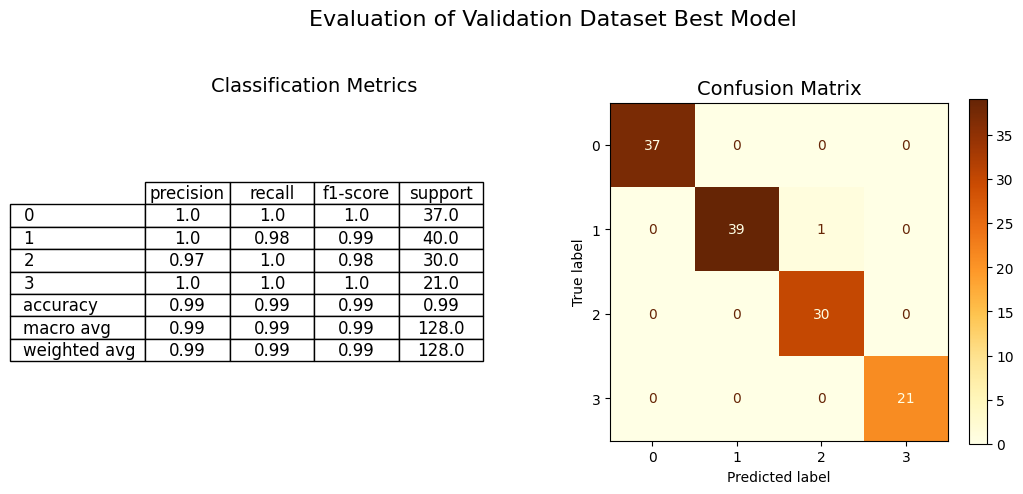

In [77]:
y_best_valid_pred_hot = best_model.predict(valid_generator)
y_best_valid_pred = np.argmax(y_best_valid_pred_hot, axis=1)
y_best_valid_true = np.argmax(np.array(list(valid_labels_dict.values())), axis=1)

display_evaluation_charts(y_best_valid_true, y_best_valid_pred, "Validation Dataset Best Model")

## Test to Unseen Dataset

4/4 [==============================] - 5s 1s/step


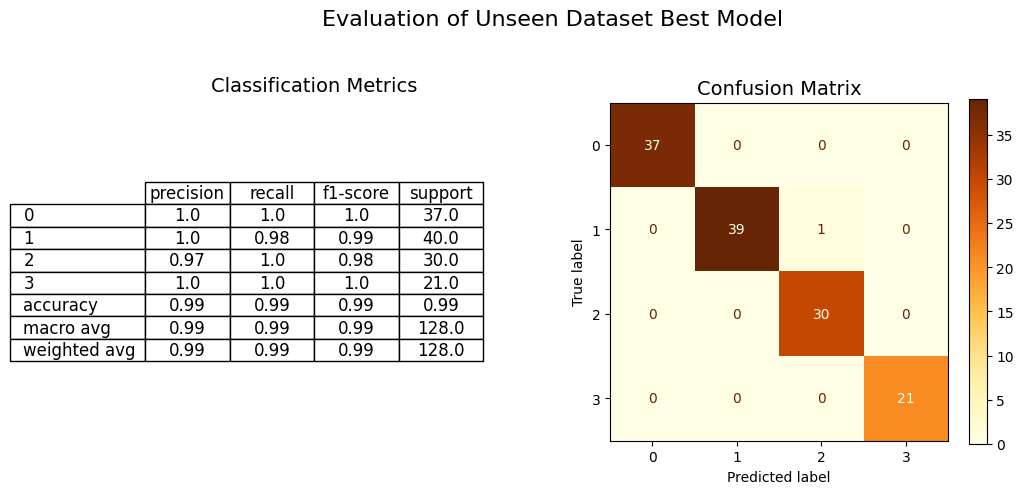

In [78]:
y_best_test_pred_hot = best_model.predict(valid_generator)
y_best_test_pred = np.argmax(y_best_test_pred_hot, axis=1)
y_best_valid_true = np.argmax(np.array(list(valid_labels_dict.values())), axis=1)

display_evaluation_charts(y_best_valid_true, y_best_test_pred, "Unseen Dataset Best Model")

After comparing the best model resulting from hyperparameter tuning with the base model, I conclude that the base model performs better. This conclusion is drawn based on the higher accuracy achieved by the base model on the training dataset (0.99) compared to the hyperparameter-tuned model (0.98). Therefore, we will select the base model with a learning rate of 0.001 and the number of neurons in the first layer set to 512.

## Save Model

In [79]:
!pip install tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 57.7 MB/s eta 0:00:00


In [81]:
import onnx
import tf2onnx

# Convert the TensorFlow model to ONNX
onnx_model, _ = tf2onnx.convert.from_keras(model)

# Save the ONNX model
onnx.save_model(onnx_model, 'base_bubble_classification.onnx')

## Recommendation

1. Add More Data:

  To improve the model's performance and generalizability, it is crucial to add more data. Increasing the dataset size can help the model learn more diverse patterns and variations, thereby reducing overfitting and enhancing its ability to make accurate predictions on unseen data. Consider collecting data from various sources and scenarios to ensure the model is exposed to a wide range of conditions.

2. Add More Data for Invalid Class:

  Specifically, the dataset should include more examples of the invalid class. This will help the model better differentiate between valid and invalid inputs, leading to more robust classification. The presence of a substantial number of invalid samples will ensure the model is well-trained to handle cases where the data does not meet the expected criteria, thereby reducing the likelihood of false positives and improving overall accuracy.

3. Add Preprocessing Threshold for Image Before Training:

  Implementing a preprocessing threshold for images before feeding them into the model can significantly enhance the training process. Preprocessing steps like thresholding can help normalize the images, remove noise, and highlight important features. This, in turn, makes it easier for the model to learn relevant patterns. Applying techniques such as binarization or adaptive thresholding can ensure that the input images are consistent and of high quality, which is critical for effective model training and performance.